# Momentum

In [1]:
from fastcore.all import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = Path('../data')

## Overview

In this article we will discuss basic windows for stock prices and test different methodologies for using them to make buy/sell decisions.  This is intended to be a first step in exploring quant trading and not a full fledged strategy or discussion of all apects of trading.  I hope that after reading this you will walk away understanding:

+ What good minimal example of a trading strategy could look like that we can build ontop of
+ How to take a concept/idea and understand what the tunable parameters/levers are
+ What are the most important things that should be top of mind when testing an approach

There are many more concepts not covered in this article that are absolutely crucial to being a successful quant.  Future articles will cover many of those concepts, but I think this will be an interesting and informative first step!

## Intuition

### Importance

Before diving into the technical bits, it is *always* a good idea to take the time to think about things at a high level and why your idea might work.  We can generate ideas *much* faster than we can code and test them, so we need to use intuition and experience to help guide us in which ideas we want to prioritize.  Intuition is important and where I start - but intuition is not reliable enough on it's own - we **must** then turn intuition into code with rigorous testing before we can decide whether to implement the strategy.  Every chapter will start with this.

### Belief

I believe how a company is doing over the last month can be used to predict how how well it will do in the future.  This isn't much of a leap, but let's think about a few reasons as to why this may be true.

+ **Available Capital:** If a company is doing well, it typically means they have more profit.  More profit means more that can be reinvested.  More reinvestment can mean faster growth.

+ **Economies of Scale:** Often the more successful a company is the more they can drive down cost in some areas.  For example, General Mills can buy sugar at a lower price than a small business due to their buying power.  As buying power increase, they can leverage that to drive down costs.
    
+ **Brand Recognition:** The more successful a business is and the larger it grows, the more brand recognition it has.  The more brand recognition it has the more it can leverage it's brand to grow.

### Hypothesis

The *hypothesis* for this chapter is that recent stock performance can be used on its own to predict future stock performance.  Regardless of how much we believe that to be true, we should not trade based on this belief until we have evidence.  This chapter will explore several options for using this hypothesis to make trades, and give a foundation in how we may test and determine whether this is an idea worth keeping.

## The Data

### Load data

First let's take a look at the data we will be using and talk a bit about it.  We can load it in with pandas.

In [3]:
raw = pd.read_csv(path/'eod-quotemedia.csv',parse_dates=['date'])
raw.head(3)

,date,ticker,adj_close
0,2013-07-01,A,29.994186
1,2013-07-02,A,29.650137
2,2013-07-03,A,29.705185


:::{note} A ticker is a symbol associated with a company.  For example Apple has the ticker `AAPL`.  To buy shares in Apple you would buy `AAPL`.

We have a dataframe that contains the `adjusted close price` for each day for each ticker in our universe.  After every transaction, the price of a stock changes slightly.  The `adjusted close price` is the last stock price of the day.  While this is not as detailed as having the price at a more granular level (second, minute, hour, etc.), called `tick` data, we can use daily close price to test many types of strategies.

A good first step is to use pandas' describe method.  As we do this we see a few good pieces of information to keep in mind:
+ Overall size of dataset - 409K rows
+ Very big range in values (~1 - ~1K), which most of them before $100

In [4]:
raw.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
adj_close,490737.0,75.100472,75.438804,1.59,36.782424,57.499593,87.4,1011.34


### Null Values

Let's take a look and make sure we don't have any null values to handle.  This is one of those things you should do with every dataset.  This is a great opportunity to show how you can add in simple tests into your code as you go, which will help you catch issues as you iterate and change things.

In [5]:
assert np.array([o==0 for o in raw.isnull().sum()]).all() == True

We also want to take a quick look at the non numberic columns to get an idea of what time frame we have and how many tickers.  This is often known from the dataset, but it is good practice to look at the dataset and ensure that your understanding of the dataset aligns with what you see in the data. 

In [6]:
print(f"Date column contains dates from {raw.date.min().date()} to {raw.date.max().date()}")

Date column contains dates from 2013-07-01 to 2017-06-30


### Lookahead bias

Let's see if all tickers in the dataset have the same start and end date.

In [7]:
ticker_cnt = len(raw.ticker.unique())

_min = raw[['ticker','date']].groupby('ticker').min()
_min = _min[_min.date != '2013-07-01'].count().date

_max = raw[['ticker','date']].groupby('ticker').max()
_max = _max[_max.date != '2017-06-30'].count().date

print(f'''Out of {ticker_cnt} tickers:
  + 20 do do not start on 2013-07-01
  + 0 do not have an entry for 2017-06-30.''')

Out of 495 tickers:
  + 20 do do not start on 2013-07-01
  + 0 do not have an entry for 2017-06-30.


Ok good thing we checked!  Let's think through what these data points mean:
+ Not all the tickers have the same start date.  This makes some intuitive sense because some of the companies may not have been founded until after the start date of the dataset.  They also may not have fit the criteria for the ticker universe (ie too small) until after the start date.
+ All of the tickers have an entry for 2017-06-30.  While it's not definitive proof of an issue, it is cause for concern.  This dataset may have a lookahead bias built in.

:::{note} Investopedia says "Look-ahead bias occurs by using information or data in a study or simulation that would not have been known or available during the period being analyzed."

The fact that every ticker still has a close price on the last day, means that as of the end of the dataset none of the companies in the dataset went out of business or were taken private.  A common reason this occurs in datasets is when a dataset is defined using future information.

For example if I look at the S&P 500 companies today and build a dataset of their stock prices over the last 5 years, every model I build will show better results than in reality.  By setting up the dataset using what is known on the last day of the period (all active S&P 500 companies), we are filtering out all companies that were in the S&P 500 but performed poorly they dropped out of the S&P 500.  We used our knowledge from today to create a historical dataset, which created bias.

When we see all tickers in the universe have a stock price on the last day, it's important to verify that this did not happen in your dataset.  When we talk about testing later, we will talk about how we can test to ensure we have accurate results.

### Reformat

Now that we have an basic idea of what's in our data we can reformat it to a format that will be easier to use for analysis.  For what we are doing we will be applying things based on ticker, so let's give each ticker it's own column.

In [12]:
df = raw.pivot(index='date', columns='ticker',values='adj_close')
df.iloc[:,:5].head(3)

ticker,A,AAL,AAP,AAPL,ABBV
date,,,,,
2013-07-01,29.994186,16.176093,81.138217,53.109173,34.924478
2013-07-02,29.650137,15.819834,80.722073,54.312247,35.428076
2013-07-03,29.705185,16.127950,81.237299,54.612043,35.444862


We can use the same describe as above to see statistics about each ticker.

In [14]:
df.iloc[:,:5].describe()

ticker,A,AAL,AAP,AAPL,ABBV
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000
mean,40.983757,37.811501,141.576280,100.360320,52.977953
std,5.850163,8.816410,26.260390,22.660593,7.897264
min,29.650137,14.770314,78.393647,53.109173,34.924478
25%,37.656517,34.383874,125.561609,87.186576,46.981317
50%,39.700762,39.218491,147.450711,102.884811,53.983957
75%,43.944859,43.681272,159.019446,114.257784,59.212432
max,60.131015,54.071539,199.374304,153.694280,70.780784


## Models

### Basic Momentum

As our first model let's do a basic momentum model.  For this we will take the percent difference between the current stock price and the stock price from a set time in the past.  As we think about this approach there are several levers we can pull time find tune our approach:
+ **Time Range:** We could use the past 5 days, or past 30 days, or the past year.  How far back should we be comparing?
+ **Threshold:** What threshold do we need to cross before we consider it momentous enough to take an action?  Is a 1%, 5%, 10%?
+ **What action?**  Is it just buy and sell?  Could we use this to short?


We will use 28 days for the time range and 8% for our threshold in this example to demonstrate the concept, but in the testing section we will show how to test different parameners.

In [278]:
def get_momentum_actions(df, n_periods,threshold):
    _x = df.shift(n_periods)
    momentum_rate = df.apply(lambda x: (x-x.shift(n_periods))/x.shift(n_periods))[n_periods:]

    actions = pd.DataFrame(np.where(momentum_rate < -threshold, 'Sell',
                           np.where(momentum_rate > threshold,  'Buy',
                                                                 '')),
                   columns=momentum_rate.columns,index=momentum_rate.index)
    return actions

In [353]:
actions = get_momentum_actions(df,n_periods=28,threshold=0.08)
actions.head(10).iloc[:,:20]

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN
date,,,,,,,,,,,,,,,,,,,,
2013-08-09,,Buy,,Buy,Buy,Buy,,,,Buy,Buy,,Buy,,,,Buy,,,
2013-08-12,,Buy,,Buy,,,,,,Buy,Buy,,Buy,,,,Buy,,Buy,
2013-08-13,Buy,,,Buy,,,,,,Buy,Buy,,Buy,Buy,,,Buy,,Buy,Buy
2013-08-14,,,,Buy,,,,,,,Buy,,Buy,,,,Buy,,,Buy
2013-08-15,,,,Buy,,,,,,,,,Buy,,,,,,,
2013-08-16,,,,Buy,,,,,,,,,Buy,,,,,,,
2013-08-19,,Sell,,Buy,,,,,,,,,Buy,,,,,,,Buy
2013-08-20,,Sell,,Buy,,,,,,,,,,,,,,,,Buy
2013-08-21,,Sell,,Buy,,,,,,,,,,,,,,,,


This leaves us with a nice table of what actions we are going to execute each day for each stock.  Let's look at some other options for using this momentum-esque concept, and then we can test them all and compare how they perform at the end.

### Regression Momentum

Our previous approach was just the % change between 2 dates.  But what if one of those days is an outlier?  Should we really make a decision based on just 2 data points?  To address these concerns we will define momentum slightly differently, with the slope of a fit regression.

If we look at this example below with Apple for a 10 day period, we see a bunch of data points.  Every 4 data points has a regression trend line fit to them.  In this way, we can use the slope of that line to determine how much momentum it has.  In this way we use all the recent data points to influence momentum and not just the first and last 

Text(0.5, 0.98, 'Window Regression Lines')

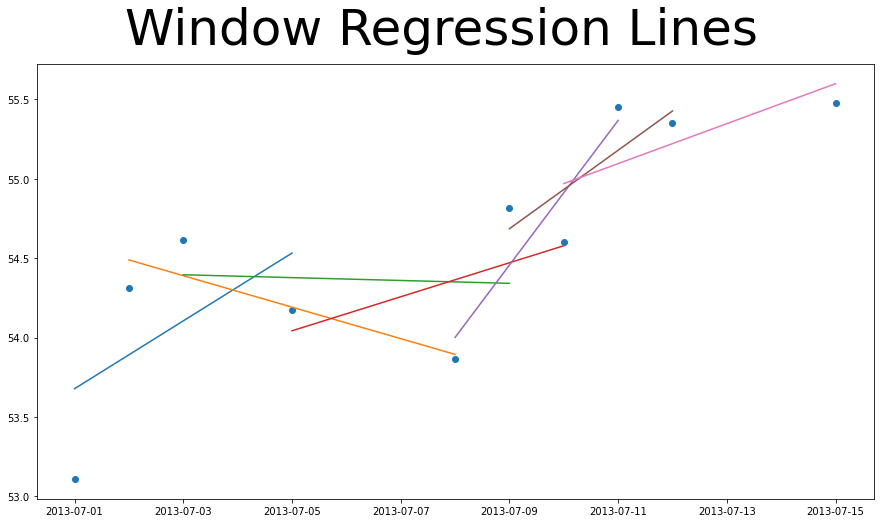

In [354]:
from sklearn.linear_model import LinearRegression

fig,ax = plt.subplots(figsize=(15,8))
_ = df['AAPL'].iloc[:10]
x1 = _.index.day.values
y1 = _.values

sz = 4
regr_y = [y1[i:i+sz] for i in range(0,len(y1)-(sz-1))]
regr_x = [x1[i:i+sz].reshape(-1, 1) for i in range(0,len(x1)-(sz-1))]

regr = [LinearRegression().fit(x,y).predict(x) for x,y in zip(regr_x,regr_y)]


regr_padded = [[None]*i+list(r)+[None]*(len(x)-sz-i) for i,r in enumerate(regr)]


ax.scatter(_.index,y1)
for i in range(len(regr)): ax.plot(_.index,regr_padded[i])

fig.suptitle("Window Regression Lines",fontsize=50)


So we take the slope of best fit for the time range window.  There are very similar levers as before we can change to fine tune out approach:
+ **Time Range:** We could use the past 5 days, or past 30 days, or the past year.  How far back should we be comparing?
+ **Threshold:** What threshold do we need to cross before we consider it momentous enough to take an action?  Is a slope of 1? Slope of 10?  Should we do something other than a set value?
+ **What action?**  Is it just buy and sell?  Could we use this to short?

We will use 28 days for the time range and $5 for our threshold in this example to demonstrate the concept, but in the testing section we will show how to test different parameters.

:::{note} In this section we are using a straight dollar threshold instead of a percentage.  This can cause difficulties because a ticker with a share price at 20 dollars increasing to 25 dollars is a HUGE increase.  If a stock goes from 500 to 505 dollars that is not nearly as big of a deal.  The point of this section is to show variety of options and get you thinking, so we will keep this one as is!

Let's codify our approach so we have a function we can use to test with later.

In [355]:
def get_momentum_regr_actions(df, n_periods,threshold):
    _x = df.shift(n_periods)
    mom_window = df.rolling(n_periods)
    mom_rate = mom_window.apply(lambda y: LinearRegression().
                                    fit(np.array(range(n_periods)).
                                    reshape(-1, 1),y).coef_)
    mom_rate = mom_rate[n_periods:]
    
    actions = pd.DataFrame(np.where(mom_rate < -threshold, 'Sell',
                           np.where(mom_rate > threshold,  'Buy',
                                                                 '')),
                   columns=mom_rate.columns,index=mom_rate.index)
    return actions

In [ ]:
actions = get_momentum_regr_actions(df,n_periods=28,threshold=.24)
actions.head(10).iloc[:,:20]

### Bollinger Bands

The idea of a bollinger band is to use a rolling standard deviation to determine when the stock price is unusually high or low.  In theory if the price is doing something unexpected we can capitalize on that.

Let's walk through graphing this on a few tickers so we understand what's going on.  Then we can test some strategies using this concept and see how they perform on this dataset.

In [ ]:
def calculate_bollinger(df, tickers=['AAPL','MSFT'],window_sz=28,band_sz=2):
    out = {}
    for ticker in tickers:
        raw = df.loc[:,ticker] 
        _mean = raw.rolling(window_sz).mean()
        _std = raw.rolling(window_sz).std()

        upper_band = _mean + (band_sz*_std)
        lower_band = _mean - (band_sz*_std)
        
        _out = pd.concat([lower_band, raw, upper_band, ],axis=1)
        _out.columns = ['lower_band','raw','upper_band']
        _out['lower_limit'] = _out.raw < _out.lower_band
        _out['upper_limit'] = _out.raw > _out.upper_band

        out[ticker] = _out
    return out
calculate_bollinger(df,['AAPL','MSFT','GOOG','AMZN'])['AAPL'].sample(3)

In [ ]:
def plot_bollinger(data,min_date,plt_cols=2):
    rows = int(len(data.keys())/plt_cols)
    fig, ax = plt.subplots(rows,plt_cols,figsize=(20,8*rows))
    fig.suptitle("Bollinger Bands",fontsize=50)

    for i,(ticker,df) in enumerate(data.items()):
        row_num = int(i / plt_cols) if len(data.keys()) > 2 else i
        col_num = i - (row_num * plt_cols)
        
        _d = data[ticker].loc[df.index>=min_date]

        if plt_cols >2: _tmp = ax[row_num,col_num]
        else: _tmp = ax[row_num]
        _tmp.set_title(ticker,fontsize=18)
        _tmp.plot(_d[['lower_band','raw','upper_band']])
        _tmp.scatter(_d[_d.lower_limit].index,_d[_d.lower_limit].raw,c='red')
        _tmp.scatter(_d[_d.upper_limit].index,_d[_d.upper_limit].raw,c='red')

plot_bollinger(calculate_bollinger(df),min_date='2016-01-01')

These charts show stock prices for Apple and Microsoft over time in orange.  The green is our upper band, which in this case is 2 standard deviations above the mean, when looking at the last 28 days of the adjusted close price.  The blue is 2 standard deviations below the mean.

We've plotted red dots anywhere the stock price crosses these bounds.  This can only happen if there is a significant enough shift for it to be 2 standard deviations from the mean.  Let's code up this third momentum-esque approach as well so we have a 3rd method to test.  Where the price crosses a bollinger band we will take an action!

In [ ]:
def get_bollinger_actions(df,window_sz=28,band_sz=2):
    
    bollinger_data = calculate_bollinger(df, tickers=df.columns,window_sz=window_sz,band_sz=band_sz)
    _d = L()
    for ticker,dataframe in bollinger_data.items():
        _d.append(pd.DataFrame(np.where(dataframe['lower_limit'] == True, 'Sell',
                           np.where(dataframe['upper_limit'] == True,  'Buy',
                                                                 '')),
                   columns=[ticker],index=dataframe.index))
    bollinger_actions = pd.concat(_d,axis=1)
    return bollinger_actions[window_sz:]

In [ ]:
actions = get_bollinger_actions(df,window_sz=28,band_sz=2)
actions.head(10).iloc[:,:20]

### Model Conclusion

As you can see we took a simple concept of price momentum and showed 3 different ways this could be applied in a model.  There are many more, and we encourage you to think of another approach and code that up!  The key insight here is to really think about how all the ways you might accomplish a task are and what parameters you can tweak.

By all means, do your research and let what has worked from others guide your tests.  But do not discard ideas you think are valuable simply because you haven't read about anyone else doing it yet.  You may come up with a novel approach!  Or it may be an approach that others are using that just hasn't been published publicly before.  Try new things, see how they work, and tweak them - that's how you build intuition.

## Testing

### Train vs Valid vs Test

### Returns

### Statistical Tests